# March Madness and Analytics:

## Can you Predict NCAA Basketball Tournament Bids from the Massey Ratings?

In another notebook, we looked at the correlation between tournament bids for men's and women's NCAA D-1 basketball teams.  We used data for rankings that were based on the [Massey Ratings](https://www.masseyratings.com).  In this notebook we try to understand the relationship between the Massey Rating and the likelihood that a team get a tournament bid. However, we want to approach this as a machine learning problem, not just as a problem in descriptive statistics.

This process is like any machine learning project in which you need to predict a binary outcome from a numeric variable (frequently a continuous variable).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from numpy import random
# Set the seed if you want to get the same results from run to run.
# random.seed(2021)

In [3]:
coin_flip = "heads" if random.rand()<0.5 else "tails"

if coin_flip == "heads":
    gender = "men"
else:
    gender = "women"

print(f' Coin flip is {coin_flip}: {gender.title()}')

 Coin flip is heads: Men


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

I downloaded Massey Ratings to the csv files `Massey_men_d1.csv` and `Massey_women_d1.csv` 
from [here](https://www.masseyratings.com/cb/ncaa-d1/ratings) for the men and
from [here](https://www.masseyratings.com/cbw/ncaa-d1/ratings) for the women. The *rating* is a continuous 
numerical variable, and it is accompanied by a *ranking* according to those values. You can read on the Massey Ratings site how they derive the ratings. In the other notebook, on Kendall's Tau, we primarily analyzed ranking. In this notebook we focus on the rating, but this entire analysis could be done using ranking as the numeric variable.

In [5]:
df_inspect = pd.read_csv(f'Massey_{gender}_d1.csv')

In [6]:
df_inspect.head()

,Team,Unnamed: 1,Record,Unnamed: 3,&Delta;,Rat,Unnamed: 6,Pwr,Unnamed: 8,Off,Unnamed: 10,Def,Unnamed: 12,HFA,SoS,Unnamed: 15,SSF,Unnamed: 17,EW,EL
0,Gonzaga,West Coast,28-0,1.000,NaN,1,9.86,1,55.92,1,109.03,74,22.58,2.78,92,34.22,89,34.59,0.80,2.000000e-01
1,Baylor,Big 12,24-2,0.923,1.0,2,9.07,4,50.17,5,100.66,25,25.20,2.93,80,35.87,75,36.25,0.63,3.700000e-01
2,Michigan,Big 10,22-4,0.846,1.0,3,8.89,5,49.50,10,98.26,17,26.93,2.92,15,40.04,13,40.26,0.62,3.800000e-01
3,Illinois,Big 10,24-7,0.774,-2.0,4,8.89,3,50.62,4,101.28,28,25.03,2.84,6,41.02,6,41.02,0.00,-8.881784e-16
4,Houston,American Athletic,26-3,0.897,1.0,5,8.75,2,51.00,22,96.67,3,30.02,3.00,106,32.79,101,33.17,0.73,2.700000e-01


In [7]:
use_cols = ['Team', 'Unnamed: 1', 'Record', 'Unnamed: 3', 'Rat', 'Unnamed: 6']
col_types = [object,object,object,float,int,float]
dtype_map = dict(zip(use_cols,col_types))

col_map = {'Unnamed: 1':'Conference',
           'Record':'Record_winloss',
           'Unnamed: 3':'Record_pct',
           'Rat':'Ranking',
           'Unnamed: 6':'Massey_rating'}


In [8]:
df_ratings = pd.read_csv(f'Massey_{gender}_d1.csv', 
                              usecols=use_cols,
                              dtype=dtype_map,
                              index_col='Team').rename(columns=col_map)

In [9]:
df_ratings.sample(5).sort_values('Massey_rating')

,Conference,Record_winloss,Record_pct,Ranking,Massey_rating
Team,,,,,
C Michigan,Mid-American,7-16,0.304,271,5.44
Boston Univ,Patriot League,7-11,0.389,254,5.61
Louisiana,Sun Belt,17-9,0.654,184,6.18
Rutgers,Big 10,16-12,0.571,34,8.04
Virginia,Atlantic Coast,18-8,0.692,26,8.13


In [10]:
df_ratings['Wins'] = df_ratings.Record_winloss.apply(lambda x: x.split('-')[0])
df_ratings['Losses'] = df_ratings.Record_winloss.apply(lambda x: x.split('-')[1])
df_ratings.drop('Record_winloss',axis=1,inplace=True)

In [11]:
df_ncaa_field = pd.read_csv(f'tournament_{gender}.csv')
df_ncaa_field['Tournament_bid'] = 1

In [12]:
df_ratings = df_ratings.merge(df_ncaa_field,on='Team',how='outer').fillna(0)

In [13]:
df_ratings.sample(5).sort_values('Massey_rating')

,Team,Conference,Record_pct,Ranking,Massey_rating,Wins,Losses,Tournament_bid
280,SE Missouri St,OH Valley,0.407,281,5.39,11,16,0.0
221,Long Beach St,Big West,0.333,222,5.81,6,12,0.0
207,St Joseph's PA,Atlantic 10,0.250,208,5.98,5,15,0.0
25,Virginia,Atlantic Coast,0.692,26,8.13,18,8,1.0
24,Oklahoma St,Big 12,0.700,25,8.15,21,9,1.0


In [14]:
df_ratings['Conf_rank'] = df_ratings.groupby('Conference').Massey_rating\
.rank(method='first',ascending=False)

In [15]:
df_bids = df_ratings.groupby('Conference')[['Tournament_bid']].sum()\
.rename(columns={'Tournament_bid':'Conf_bids'})
df_ratings = df_ratings.merge(df_bids, on='Conference')

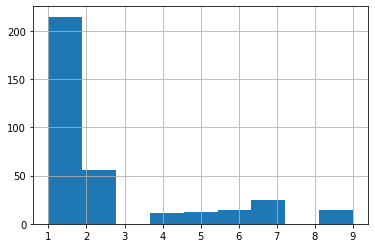

In [16]:
df_ratings.Conf_bids.hist(bins=int(df_ratings.Conf_bids.max()));

In [17]:
df_ratings['Conf_bids'] = df_ratings['Conf_bids'].apply(lambda x: 'OneOrTwo' if x<=2 else 'Multiple')

In [18]:
df_ratings.groupby('Conf_bids').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Conf_bids,,,,,,,,
Multiple,76.0,7.761711,0.601027,6.30,7.445,7.84,8.20,9.07
OneOrTwo,271.0,6.011734,0.916324,3.14,5.405,5.93,6.61,9.86


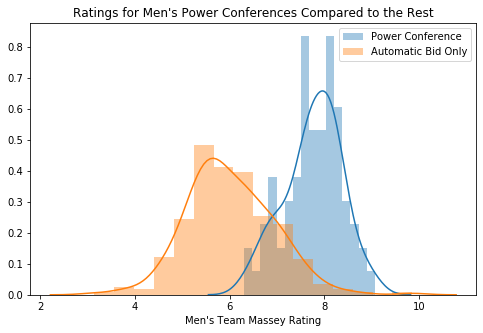

In [19]:
plt.figure(figsize=(8,5))
df_ratings.groupby('Conf_bids').apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Power Conference','Automatic Bid Only']);
plt.xlabel(f"{gender.title()}'s Team Massey Rating")
plt.title(f"Ratings for {gender.title()}'s Power Conferences Compared to the Rest");

## How do the ratings compare between the teams with and without tournament bids?

We start by just looking at some descriptive statistics using the `groupby` and `describe` methods.

In [20]:
df_ratings.groupby('Tournament_bid').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Tournament_bid,,,,,,,,
0.0,279.0,6.062294,0.911219,3.14,5.41,5.99,6.725,8.05
1.0,68.0,7.760147,0.838681,5.67,7.29,8.01,8.240,9.86


For the men and women we see that mean ratings between the teams getting tournament bids and those who did not are fairly well separated. For the men the means differed by 1.70 points with standard deviations under 1.0. For the women the means were a little closer with a difference of 1.27 and standard deviations in the neighborhood of 1.2.

From a stats perspective, we can conduct a t-test for independent samples. Here we see that Student's t statistic is 13.4 for the women with a corresponding p-value that is extremely small at 2.7e-23. Results for the men are similar. See the documentation at [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for details.
(I have set the keyword argument `equal_var` to `False`, but we might reasonably be able to assume `True`.)

In [21]:
from scipy.stats import ttest_ind

In [22]:
teams_grouped = df_ratings.groupby('Tournament_bid')

a = np.array(teams_grouped.get_group(True).Massey_rating)
b = np.array(teams_grouped.get_group(False).Massey_rating)

ttest_ind(a,b,axis=0,equal_var=False)

Ttest_indResult(statistic=14.711208459053102, pvalue=1.2228530308664051e-27)

Here we plot histograms of the subgroups.

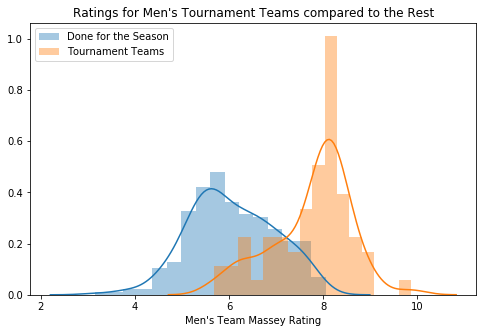

In [23]:
plt.figure(figsize=(8,5))
teams_grouped.apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel(f"{gender.title()}'s Team Massey Rating")
plt.title(f"Ratings for {gender.title()}'s Tournament Teams compared to the Rest");

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [25]:
df_ratings['Conf_bids'] = df_ratings.Conf_bids.apply(lambda x: 1 if x=='Multiple' else 0)

feature_set = ['Record_pct', 'Ranking', 'Wins', 'Losses', 'Conf_rank', 'Conf_bids']
target_set = ['Tournament_bid']

X = np.array(df_ratings[feature_set]).reshape(-1,len(feature_set))
y = np.array(df_ratings[target_set]).reshape(-1,len(target_set))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=42,
                             max_depth=4,
                             min_samples_leaf=3,
                             min_impurity_decrease=.01)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.01, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

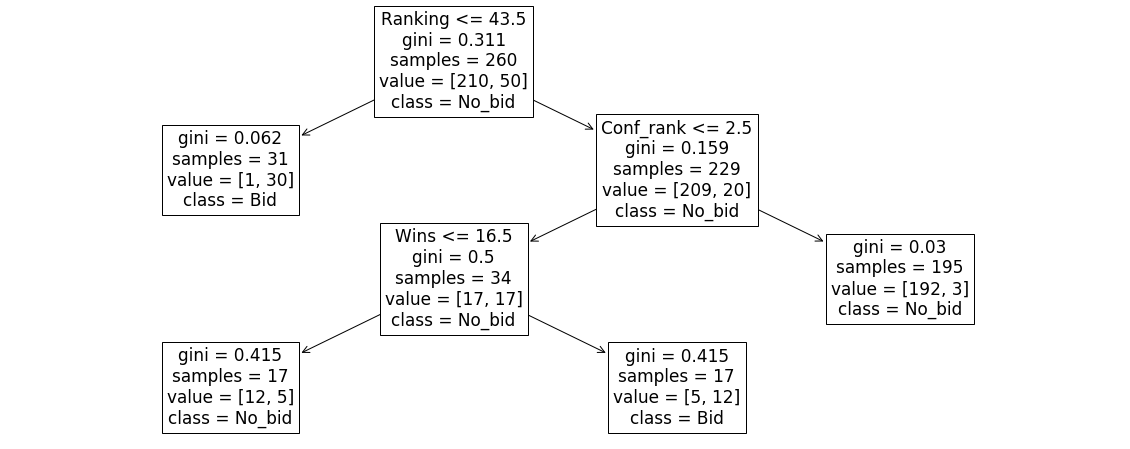

In [26]:
plt.figure(figsize=(20,8))
tree.plot_tree(clf,
               feature_names=feature_set,
               class_names=['No_bid','Bid'])
plt.show()

In [27]:
clf.score(X_test,y_test)

0.9080459770114943

In [28]:
df_sample = df_ratings.sample(25)

X_sample = np.array(df_sample[feature_set]).reshape(-1,len(feature_set))
df_sample['Model_prediction'] = clf.predict(X_sample)

df_sample.sort_values('Ranking',ascending=True)

,Team,Conference,Record_pct,Ranking,Massey_rating,Wins,Losses,Tournament_bid,Conf_rank,Conf_bids,Model_prediction
0,Gonzaga,West Coast,1.000,1,9.86,28,0,1.0,1.0,0,1.0
34,Houston,American Athletic,0.897,5,8.75,26,3,1.0,1.0,0,1.0
14,Oklahoma St,Big 12,0.700,25,8.15,21,9,1.0,5.0,1,1.0
85,Georgetown,Big East,0.500,55,7.68,13,13,1.0,5.0,1,0.0
88,Marquette,Big East,0.481,70,7.48,13,14,0.0,8.0,1,0.0
89,Providence,Big East,0.500,71,7.47,13,13,0.0,9.0,1,0.0
102,Notre Dame,Atlantic Coast,0.423,83,7.29,11,15,0.0,11.0,1,0.0
147,Marshall,Conference USA,0.682,99,7.07,15,7,0.0,5.0,0,0.0
180,Colgate,Patriot League,0.875,100,7.06,14,2,1.0,1.0,0,0.0
5,San Francisco,West Coast,0.440,107,6.98,11,14,0.0,6.0,0,0.0


array(['Losses', 'Conf_rank', 'Ranking', 'Conf_bids'], dtype='<U10')

Features: Conf_rank, Conf_bids, Record_pct, Losses
Accuracy: 0.897


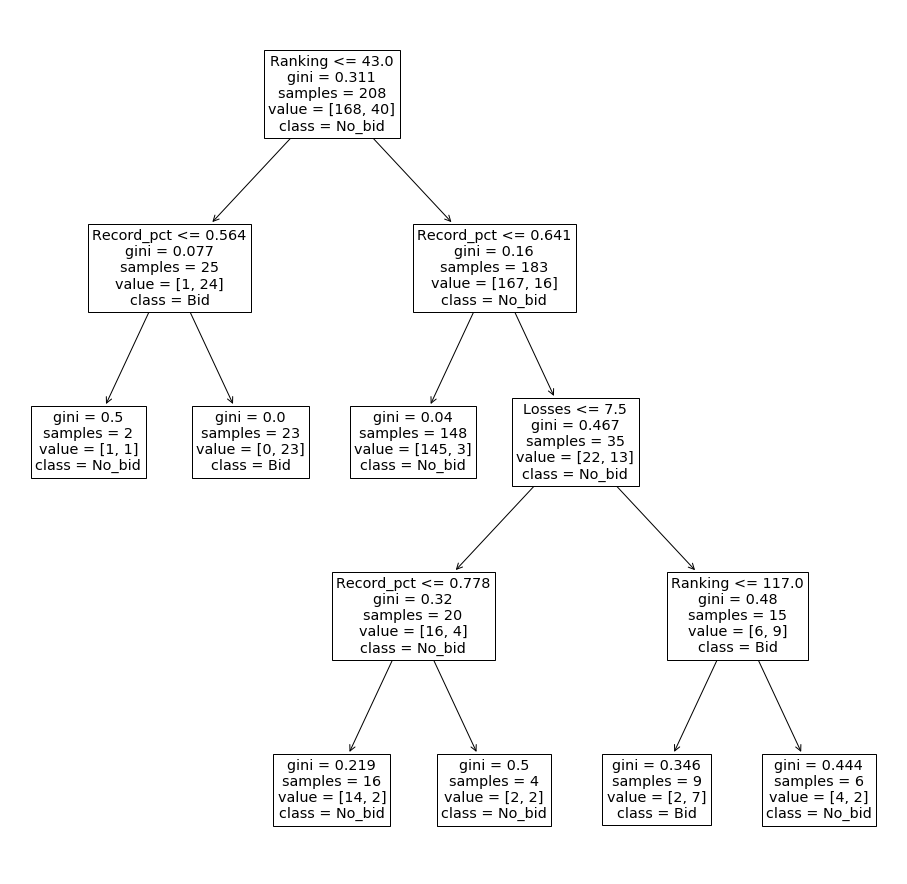

In [99]:
random_features = list(random.choice(feature_set,4,replace=False))
target_set = ['Tournament_bid']
print("Features: " + ', '.join(random_features))
num_rows,num_cols = X_train.shape
random_rows = np.sort(random.choice(np.arange(num_rows),int(num_rows*0.8),replace=False))
random_cols = np.sort(random.choice(np.arange(num_cols),int(num_cols*0.8),replace=False))

clf_rand = DecisionTreeClassifier(random_state=42,
                             max_depth=4,
                             min_samples_leaf=2,
                             min_impurity_decrease=.004)
clf_rand.fit(X_train[list(random_rows),:][:,list(random_cols)], y_train[list(random_rows)])

plt.figure(figsize=(16,16))
tree.plot_tree(clf_rand,
              feature_names=[feature_set[i] for i in random_cols],
               class_names=['No_bid','Bid']);

print(f'Accuracy: {clf_rand.score(X_test[:,random_cols],y_test):.3f}')